# Задача обучить модель word2vec на базе датасета Симпсонов
Загрузим и преобработаем тескты 

In [2]:
import multiprocessing
import re
from collections import defaultdict
from time import time

import gensim
import matplotlib.pyplot as plt

import numpy as np
import spacy
from gensim import models
from gensim.models import Word2Vec
import nltk
import pandas as pd

In [50]:
data = pd.read_csv('data/simpsons_script_lines.csv', on_bad_lines='skip')
data.dropna(subset=["spoken_words" ], inplace=True)
data = data.dropna().reset_index(drop=True)

C:\Users\daimond025\AppData\Local\Temp\ipykernel_14372\61008205.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/simpsons_script_lines.csv', on_bad_lines='skip')


In [51]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['spoken_words'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85875, 1)

In [52]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [53]:
sentences[0]

['actually',
 'little',
 'disease',
 'magazine',
 'news',
 'show',
 'natural',
 'think']

In [54]:
sentences[-1]

['psy', 'cho', 'ma', 'tic']

## Построим обучим и сохраним  модель  

In [24]:
import multiprocessing
cores = multiprocessing.cpu_count()

from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.save("word2vec.model")

### Найдем ближайшие слова 

In [25]:
w2v_model = Word2Vec.load("word2vec.model")

In [27]:
w2v_model.wv.most_similar([w2v_model.wv.get_vector('homer') - w2v_model.wv.get_vector('marge') + w2v_model.wv.get_vector('bart')], topn=3)

[('bart', 0.792990505695343),
 ('homer', 0.6623241305351257),
 ('bored', 0.6118556261062622)]

In [29]:
w2v_model.wv.most_similar([w2v_model.wv.get_vector('bart') - w2v_model.wv.get_vector('lisa') + w2v_model.wv.get_vector('school')], topn=3)

[('school', 0.9287328124046326),
 ('elementary', 0.7178175449371338),
 ('assembly', 0.6821054816246033)]

In [33]:
w2v_model.wv.most_similar([w2v_model.wv.get_vector('marge') - w2v_model.wv.get_vector('homer') + w2v_model.wv.get_vector('home')], topn=3)

[('home', 0.8393024802207947),
 ('bedroom', 0.5885391235351562),
 ('come', 0.5865676999092102)]

### Визуализировать embeddings по самым частотным словам (top 1000)

In [42]:
w2v_model = Word2Vec.load("word2vec.model")

In [43]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

def get_first_n_items(my_dict, n):
    import itertools
    return dict(itertools.islice(my_dict.items(), n))
word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
first_1000 = get_first_n_items(word_freq, 1000)

In [46]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word, count in first_1000.items():
        if word in model.wv.key_to_index.keys():
            index_word = model.wv.key_to_index[word]
            tokens.append(list(model.wv[index_word]))
            labels.append(word)

    from sklearn.manifold import TSNE
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(30, 30))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

D:\Study\netology\module_1\pythonProject\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


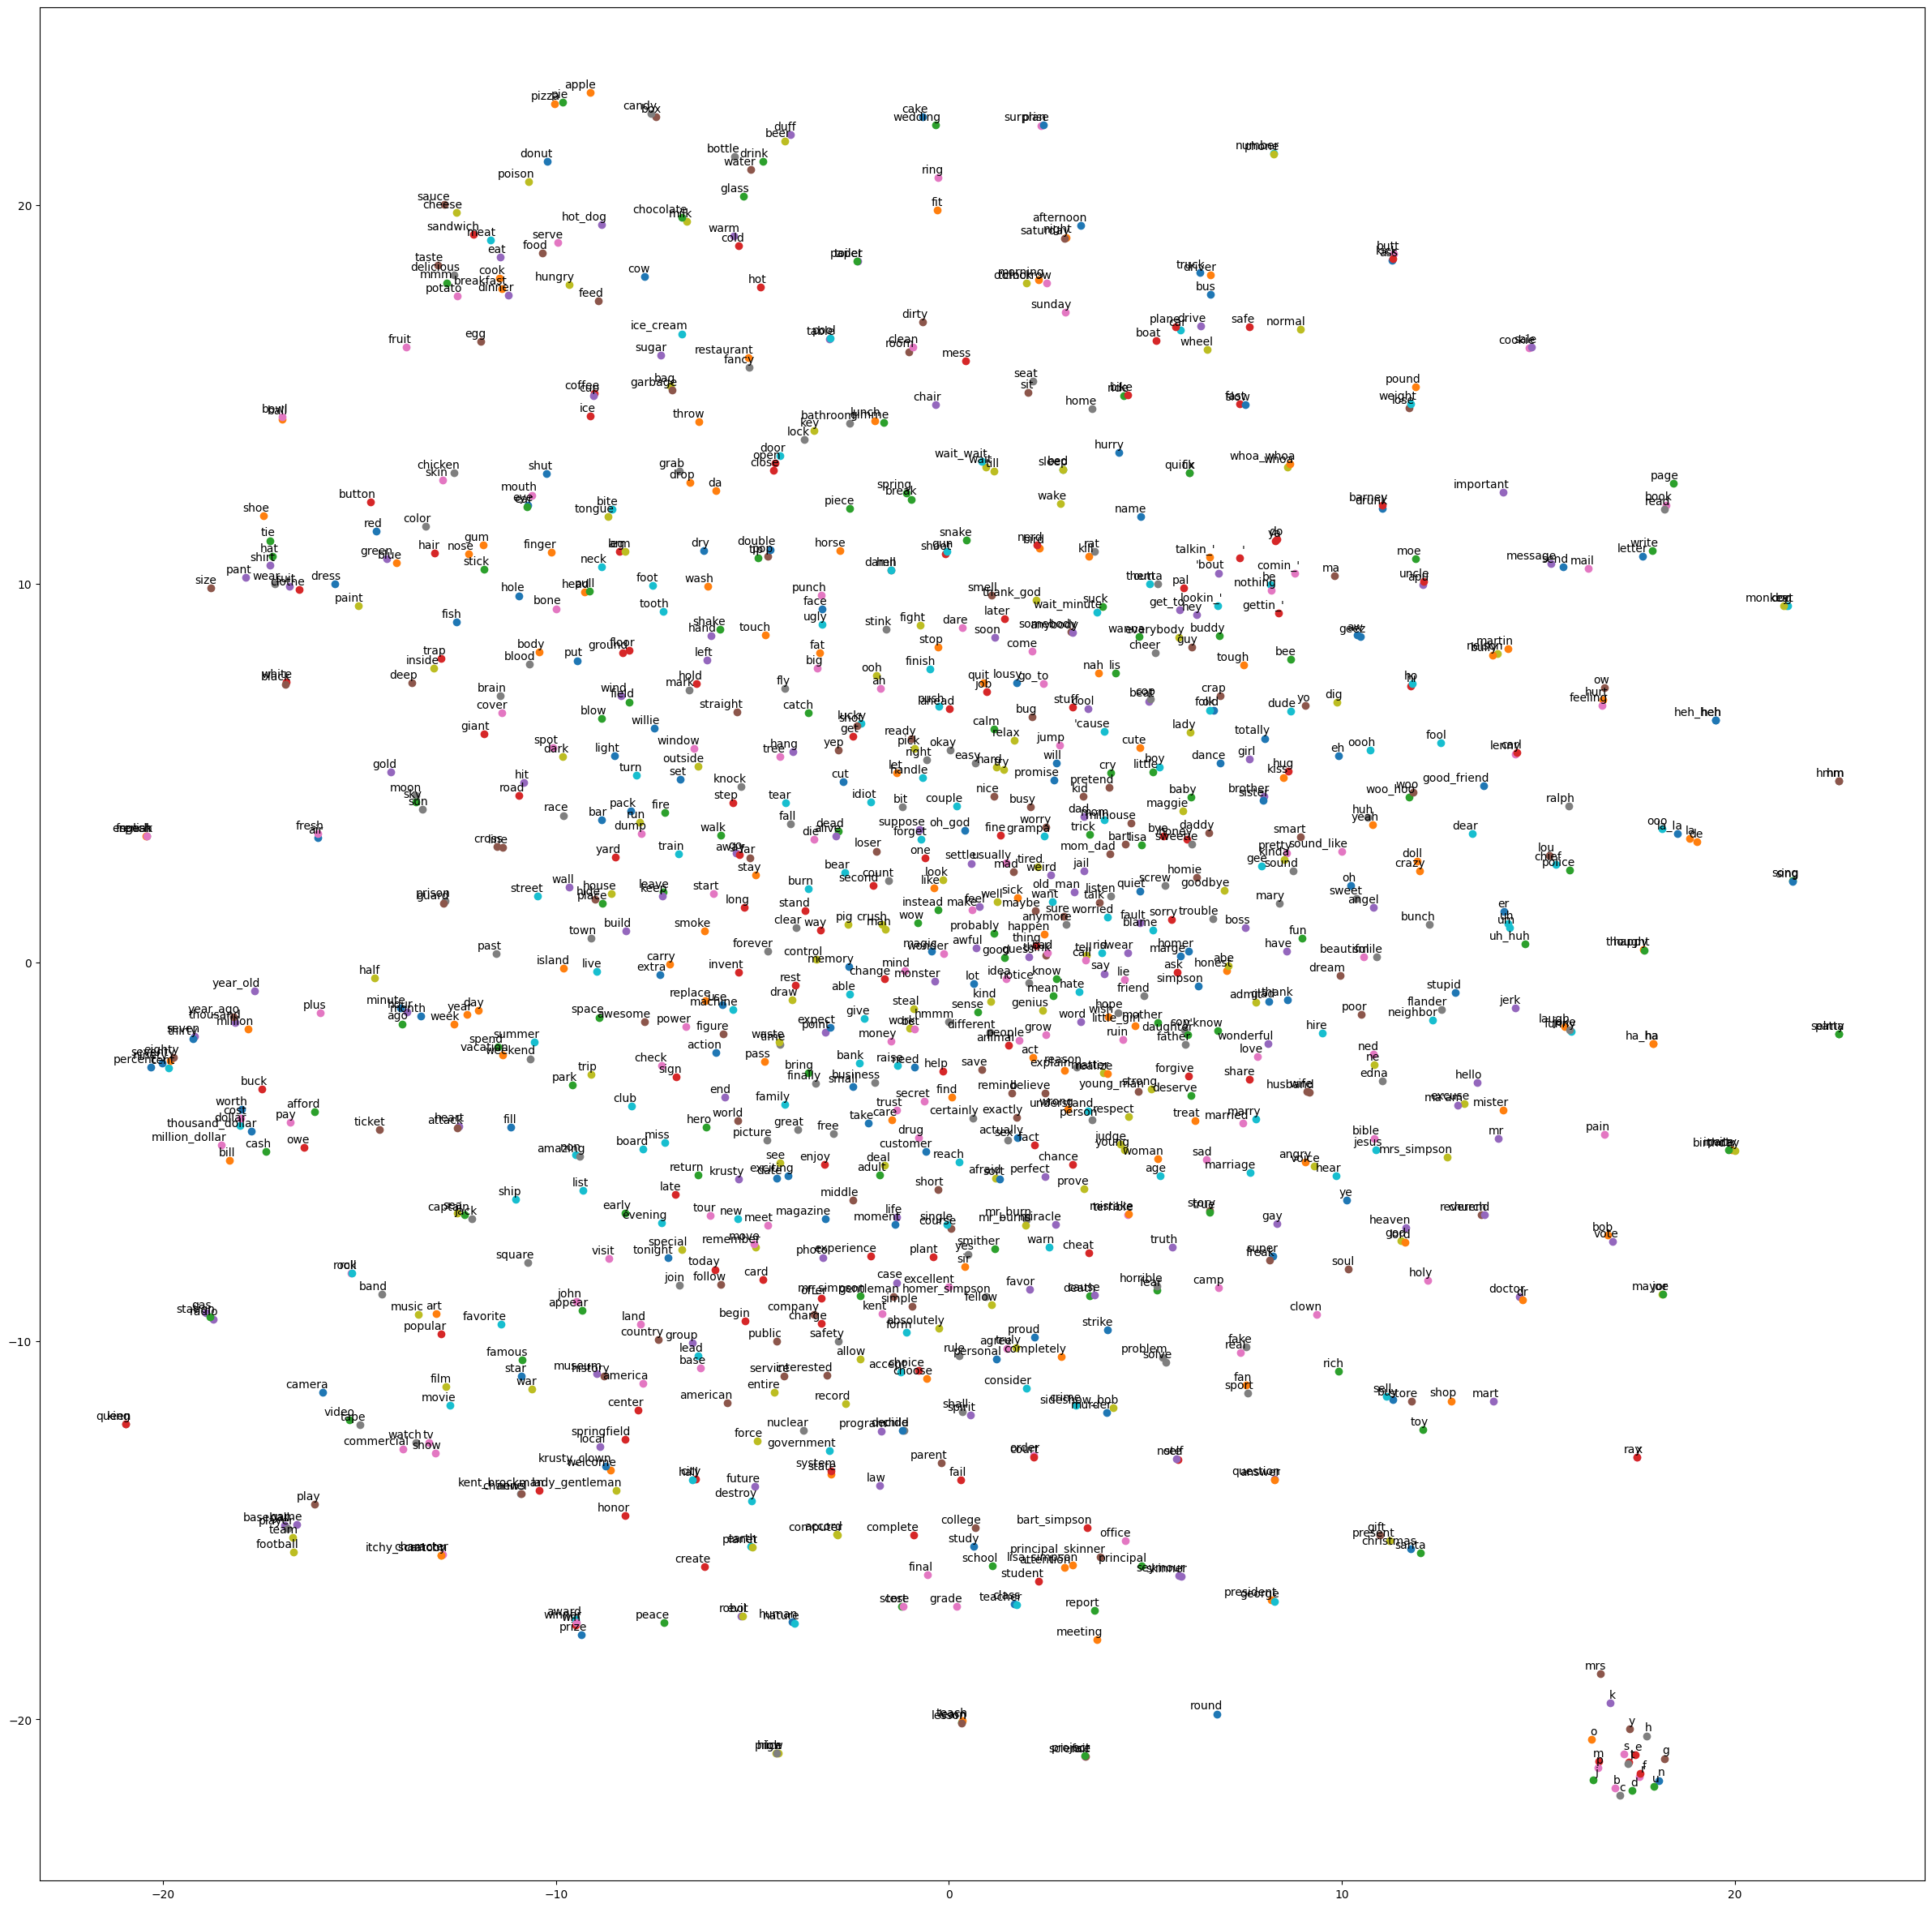

In [47]:
tsne_plot(w2v_model)

In [ ]:
##  